# Introduction to Data Science, CS 5963 / Math 3900
## Lecture 8: Classification, k nearest neighbors, and generalizability

We continue discussing classification problems and introduce the k nearest neighbors (k-NN) method. In the process, we introduce the Python library [scikit-learn](http://scikit-learn.org/). We conclude with a discussion of generalizability and cross validation, a general method that can be used to choose the parameter k in k-NN.

Recommended Reading: ISLR, Ch. 4 and Grus Ch. 12. 

Lecture is in part based on [this blog](https://blog.cambridgecoding.com/2016/03/24/misleading-modelling-overfitting-cross-validation-and-the-bias-variance-trade-off/). 

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.datasets import make_moons, load_iris
from sklearn.cross_validation import train_test_split
#import statsmodels.formula.api as sm

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

## Classification

Recall that in *classification* we attempt to predict a categorical (qualitative) variable based on based on several features or attributes. This differs from *regression*, where we try to predict a real-valued (quantitative) variable. 

**Setup:** Given $n$ samples $(x_1,y_1), (x_2,y_2),\ldots,(x_n,y_n)$, where $x_i$ are attributes or features and $y_i$ are categorical variables that you want to predict. 

** A synthetic dataset:** Let's consider a synthetic dataset in the shape of "two moons". Here, sample $i$ has two types of information, the features, denoted by $x_i$, and a class, denoted by $y_i$. Here the features are coordinates and the classes are 0 and 1. 

This dataset is generated by sampling from a distribution associated with each class, that is roughly "moon shaped". In this case, the features are these two coordinates. 

** Classification Goal:** Create a rule that can be used to assign new observations (not in the sample) a class $y$ (either 0 or 1), based on the features $x$ of the point. 



[[ 0.50316464  0.11135559  1.        ]
 [ 1.06597837 -0.63035547  1.        ]
 [ 0.95663377  0.58199637  0.        ]
 [ 0.33961202  0.40713937  0.        ]
 [ 2.17952333 -0.08488181  1.        ]
 [ 2.00520942  0.7817976   1.        ]
 [ 0.12531776 -0.14925731  1.        ]
 [ 1.06990641  0.36447753  0.        ]
 [-0.76391099 -0.6136396   0.        ]
 [ 0.55678871  0.8810501   0.        ]]


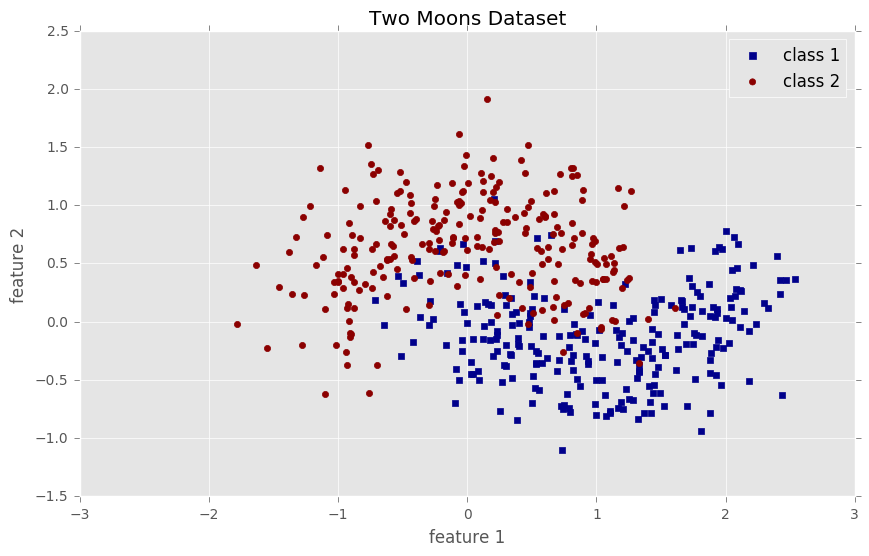

In [2]:
# there are two features contained in X and the labels are contained in y
X,y = make_moons(n_samples=500,random_state=1,noise=0.3)

print(np.concatenate((X,y[:, np.newaxis]),axis=1)[:10,:])

# Plot the data, color by class
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="DarkBlue", marker="s",label="class 1")
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="DarkRed", marker="o",label="class 2")
plt.legend(scatterpoints=1)
plt.title('Two Moons Dataset')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.show()

## Logistic Regression 

**Main idea:** Given the predictor variable  X, we model the *probability* that $Y = 1$ by 
$$
p(X) = p(Y = 1 | \ X) = \frac{e^{\beta_0 + \beta_1 X}}{1+ e^{\beta_0 + \beta_1 X}} = \textrm{logistic}(\beta_0 + \beta_1 X ). 
$$

Defining the *logit function* to be the inverse of the logistic function by $\textrm{logit}$, we have that 
$$
\textrm{logit} ( p(X) ) = \beta_0 + \beta_1 X.  
$$
We interpret this to mean that the log odds of the probability of a predictor variable $X$ being a member of class $Y=1$ is linear. *Logistic Regression* finds the *best* parameters $\beta_0$ and $\beta_1$ in this model. 

Let's see how to use the Python library [scikit-learn](http://scikit-learn.org/) for logistic regression. 

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(500, 2) (500,)


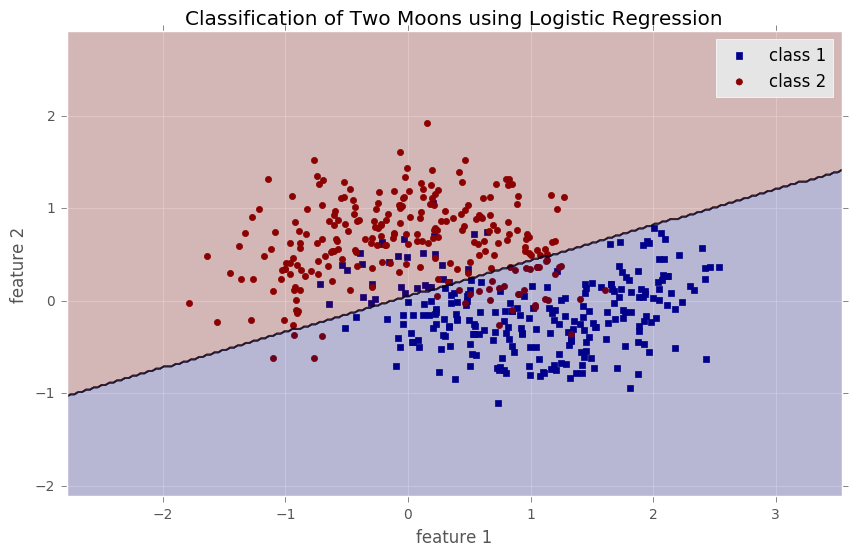

Confusion Matrix:
[[212  38]
 [ 32 218]]
Accuracy =  0.86


In [3]:
# set up the model 
# we could specify parameters here, but we'll just use the default ones
model = LogisticRegression() 

# X is a 500x2 numpy.ndarray containing the coordinates for each sample
# y is a 500x1 numpy.ndarray containing the class for each sample
print(type(X), type(y)) 
print(np.shape(X), np.shape(y))

# use the model to fit the data
model.fit(X, y)

# Plot the data, color by class
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="DarkBlue", marker="s",label="class 1")
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="DarkRed", marker="o",label="class 2")
plt.legend(scatterpoints=1)

# Plot the predictions made by Logistic Regression
x_min, x_max = X[:,0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),np.linspace(y_min, y_max, 200))
zz = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, zz, cmap=ListedColormap(['DarkRed', 'DarkBlue']), alpha=.2)
plt.contour(xx, yy, zz, colors="black", alpha=1, linewidths=0.2) 

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Classification of Two Moons using Logistic Regression')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.show()

print('Confusion Matrix:')
y_pred = model.predict(X)
print(metrics.confusion_matrix(y_true = y, y_pred = y_pred))

print('Accuracy = ', metrics.accuracy_score(y_true = y, y_pred = y_pred))

## Another method for classification:  k Nearest Neighbors (k-NN) 

**Idea:** To decide the class of a given point, find the k nearest neighbors of that point, and let them "vote" on the class. That is, we assign the sample to the class most common among its k nearest neighbors. 

**Considerations:**
1. We must pick k, the number of voting neighbors (typically a small number, say k=10)
+ 'Nearest' means closest in distance, so there is some flexibility in defining the distance
+ There are different ways to vote. For example, of the k nearest neighbors, I might give the closest ones more weight than farther ones. 
+ We have to decide how to break ties in the vote. 

### Dataset: The Iris dataset

This dataset was introduced in 1936 by the statistician [Sir Ronald A. Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher). 

The dataset contains 4 features (attributes) of 50 samples containing 3 different types of iris plants. The goal is to classify the type of iris plant given the attributes. 

**Features (attributes):**
1. sepal length (cm) 
+ sepal width (cm) 
+ petal length (cm) 
+ petal width (cm) 

**Classes:**
1. Iris Setosa 
+ Iris Versicolour 
+ Iris Virginica

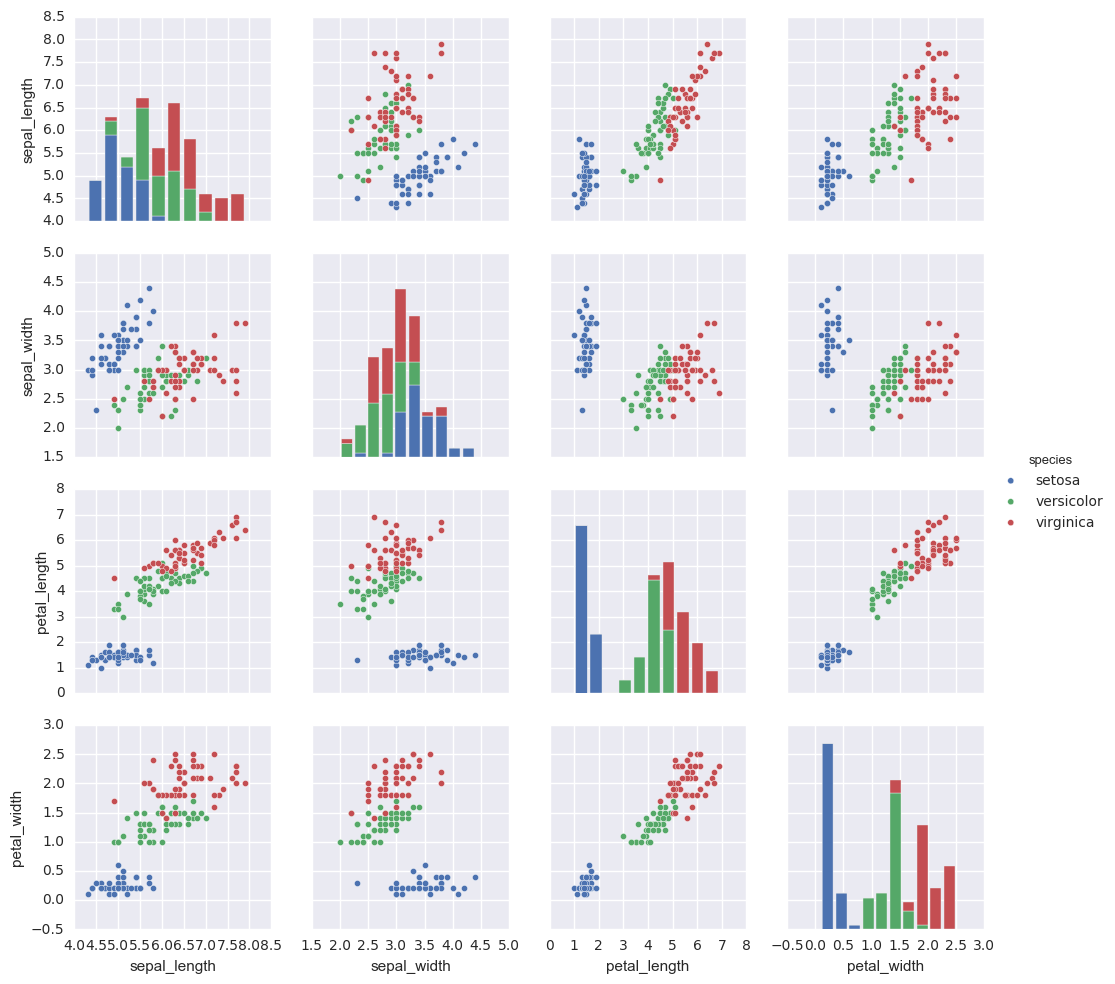

In [4]:
# the seaborn library 
# https://stanford.edu/~mwaskom/software/seaborn/
# is for visualizing data 
# but has to be installed seperately
# conda install seaborn

import seaborn as sns
sns.set()

df = sns.load_dataset("iris") # built-in dataset in seaborn 
sns.pairplot(df, hue="species")

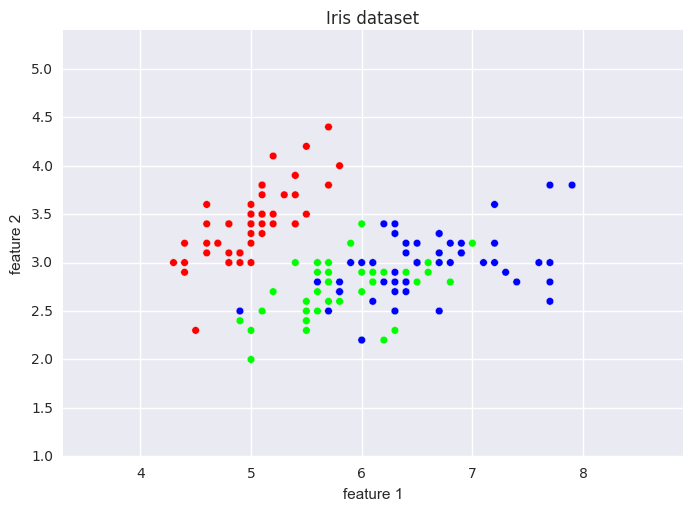

In [5]:
# import data, scikit-learn also has this dataset built-in
iris = load_iris()

# For easy plotting and interpretation, we only use first 2 features here. 
# We're throwing away useful information - don't do this at home! 
X = iris.data[:,:2]  
y = iris.target

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# plot data
plt.scatter(X[:, 0], X[:, 1], c=y,  marker="o", cmap=cmap_bold, s=30)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)    
plt.title('Iris dataset')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.show()

We see that it would be fairly easy to separate the "red" irises from the two classes. However, separating the "green" and "blue" ones would be a challenge. 

There are three classes, so we can't apply logistic regression. (This isn't completely true; there are extensions of logistic regression to handle more classes, but these are not very popular.)

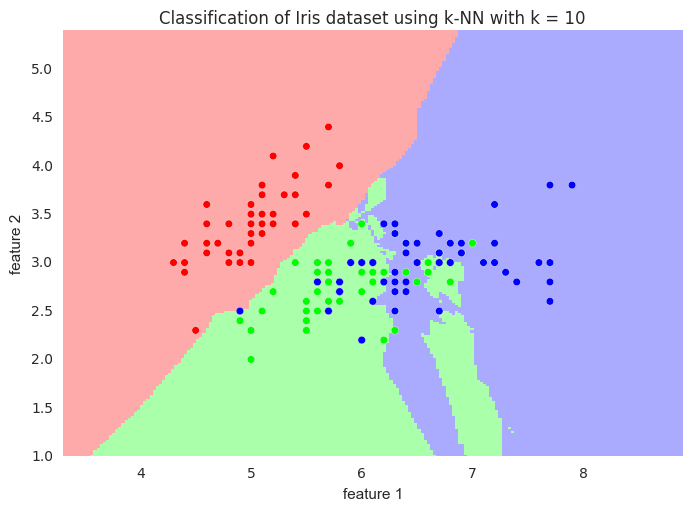

Confusion Matrix:
[[50  0  0]
 [ 0 40 10]
 [ 0 13 37]]
Accuracy =  0.846666666667


In [6]:
# set up the model, k-NN classification with k = ?  
k = 10
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(X, y)

# plot classification 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),np.linspace(y_min, y_max, 200))
zz = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, zz, cmap=cmap_light)

# plot data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,s=30)

plt.title('Classification of Iris dataset using k-NN with k = '+ str(k))
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)    
plt.show()

print('Confusion Matrix:')
y_pred = clf.predict(X)
print(metrics.confusion_matrix(y_true = y, y_pred = y_pred))

print('Accuracy = ', metrics.accuracy_score(y_true = y, y_pred = y_pred))

**Some preliminary comments on the parameter, $k$:** 

- For k large (say $k=100$), the *decision boundary* (boundary between classes) becomes more smooth. The model is not very complex - it could basically be described by a line. The model is stable in the sense that if the data were to change slightly, the model wouldn't change much. (There are many voters.) Since the model doesn't depend on the data very much, we might expect that it would *generalize* to new data points. 

- For k small (say $k=1$), the decision boundary is very wiggly (wiggle-docious anyone?). The model is very complex - it definitely isn't described by a single line. If the model is unstable in the sense that if the data were to change slightly, the model would change quite a bit. Since the model is very dependent on the dataset, we would say that it wouldn't generalize to new data points well. In this case, we would say that the model has overfit the data. (We saw a similar phenomena in regression using high degree polynomials.) 


**Questions:**
1. How to choose k? (more on this below)
+ Which does a better job on the moons dataset: k-NN or logistic regression?

To the moons!

In [7]:
# moons
X,y = make_moons(n_samples=500,random_state=1,noise=0.3)

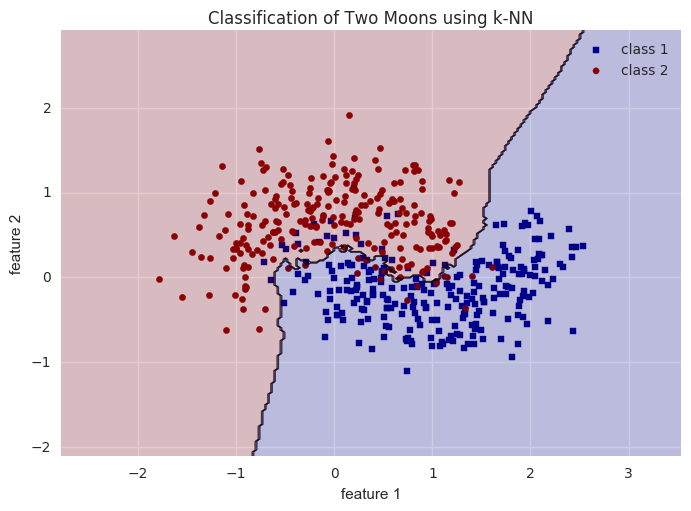

Confusion Matrix:
[[232  18]
 [ 26 224]]
Accuracy =  0.912


In [8]:
model = KNeighborsClassifier(n_neighbors = 10)
model.fit(X, y)

# Plot the data, color by class
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="darkblue", marker="s",label="class 1")
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="darkred", marker="o",label="class 2")
plt.legend(scatterpoints=1)

# Plot the predictions made by Logistic Regression
x_min, x_max = X[:,0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),np.linspace(y_min, y_max, 200))
zz = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, zz, cmap=ListedColormap(['DarkRed', 'DarkBlue']), alpha=.2)
plt.contour(xx, yy, zz, colors="black", alpha=1, linewidths=0.2) 

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.title('Classification of Two Moons using k-NN')

plt.show()

print('Confusion Matrix:')
y_pred = model.predict(X)
print(metrics.confusion_matrix(y_true = y, y_pred = y_pred))

print('Accuracy = ', metrics.accuracy_score(y_true = y, y_pred = y_pred))

For *good* choices of the parameter k, k-NN is a better classifier than logistic regression. Logistic regression suffers because the decision boundary isn't curved. For this reason, it is called a *linear classifier).  (However there are extensions to logistic regression that allow the decision boundary to curve). 



# Model generalizability and cross-validation

In classification, and other prediction problems, we would like to develop a model on a dataset, the *training dataset*, that will not only perform well on that dataset but on similar data that the model hasn't yet seen, the *testing dataset*. If a model satisfies this criterion, we say that it is *generalizable*. 

If a model has 100% accuracy on the training dataset ($k=1$ in k-NN) but doesn't generalize to new data, then it isn't a very good model. We say that this model has *overfit* the data. On the other hand, it isn't difficult to see that we could also *underfit* the data (taking $k$ large in k-NN). In this case, the model isn't complex enough to have good accuracy on the training dataset. 

**Cross-validation** is a general method for assessing how the results of a model (classification, regression,...) will *generalize* to an independent data set. In classification, cross-validation is a method for assessing how well the classification model will predict the class of points that weren't used to *train* the model. 

The idea of the method is simple: 
1. Split the dataset into two groups: the training dataset and the testing dataset. 
+ Train the model on the training dataset. 
+ Check the accuracy of the model on the testing dataset. 

In practice, you have to decide how to split the data into groups (i.e. how large the groups should be). You might also want to repeat the experiment so that the assessment doesn't depend on the way in which you split the data into groups. We'll worry about this in a later lecture. 

For now, I just want you to conceptually understand how generalizable k-NN is as we vary the parameter, k. 

<img src="https://cambridgecoding.files.wordpress.com/2016/03/figures_mod4_over_underfitting.png?w=1220&h=1612" width="500">

$\qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad$ 
source: [this blog](https://blog.cambridgecoding.com/2016/03/24/misleading-modelling-overfitting-cross-validation-and-the-bias-variance-trade-off/)

As the model becomes more complex (k decreases), the accuracy always increases for the training dataset. But, at some point, it starts to overfit the data and the accuracy decreases for the test dataset! Cross validation techniques will allow us to find the sweet-spot for the parameter k! (Think: Goldilocks and the Three Bears.)


Let's see this concept for the two moons dataset. You can use the *train_test_split* function i scikit-learn to split the dataset into a training dataset and a test dataset. 

In [11]:
def detect_plot_dimension(X, h=0.02, b=0.05):
    x_min, x_max = X[:, 0].min() - b, X[:, 0].max() + b
    y_min, y_max = X[:, 1].min() - b, X[:, 1].max() + b
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    dimension = xx, yy
    return dimension
 
def detect_decision_boundary(dimension, model):
    xx, yy = dimension  # unpack the dimensions
    boundary = model.predict(np.c_[xx.ravel(), yy.ravel()])
    boundary = boundary.reshape(xx.shape)  # Put the result into a color plot
    return boundary
 
def plot_decision_boundary(panel, dimension, boundary, colors=['#DADDED', '#FBD8D8']):
    xx, yy = dimension  # unpack the dimensions
    panel.contourf(xx, yy, boundary, cmap=ListedColormap(colors), alpha=1)
    panel.contour(xx, yy, boundary, colors="g", alpha=1, linewidths=0.5)  # the decision boundary in green
 
def plot_dataset(panel, X, y, colors=["#EE3D34", "#4458A7"], markers=["x", "o"]):
    panel.scatter(X[y == 1, 0], X[y == 1, 1], color=colors[0], marker=markers[0])
    panel.scatter(X[y == 0, 0], X[y == 0, 1], color=colors[1], marker=markers[1])
 
def calculate_prediction_error(model, X, y):
    yPred = model.predict(X)
    score = round(metrics.accuracy_score(y, yPred), 2)
    return score
 
def plot_prediction_error(panel, dimension, score, b=.3):
    xx, yy = dimension  # unpack the dimensions
    panel.text(xx.max() - b, yy.min() + b, ('%.2f' % score).lstrip('0'), size=15, horizontalalignment='right')
 
def explore_fitting_boundaries(model, n_neighbors, datasets, width):  
    # determine the height of the plot given the aspect ration of each panel should be equal
    height = float(width)/len(n_neighbors) * len(datasets.keys())
 
    nrows = len(datasets.keys())
    ncols = len(n_neighbors)
 
    # set up the plot
    figure, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(width, height),
        sharex=True,
        sharey=True
    )
 
    dimension = detect_plot_dimension(X, h=0.02)  # the dimension each subplot based on the data
 
    # Plotting the dataset and decision boundaries
    i = 0
    for n in n_neighbors:
        model.n_neighbors = n
        model.fit(datasets["Training Set"][0], datasets["Training Set"][1])
        boundary = detect_decision_boundary(dimension, model)
        j = 0
        for d in datasets.keys():
            try:
                panel = axes[j, i]
            except (TypeError, IndexError):
                if (nrows * ncols) == 1:
                    panel = axes
                elif nrows == 1:  # if you only have one dataset
                    panel = axes[i]
                elif ncols == 1:  # if you only try one number of neighbors
                    panel = axes[j]
            plot_decision_boundary(panel, dimension, boundary)  # plot the decision boundary
            plot_dataset(panel, X=datasets[d][0], y=datasets[d][1])  # plot the observations
            score = calculate_prediction_error(model, X=datasets[d][0], y=datasets[d][1])
            plot_prediction_error(panel, dimension, score, b=0.2)  # plot the score
 
            # make compacted layout
            panel.set_frame_on(False)
            panel.set_xticks([])
            panel.set_yticks([])
 
            # format the axis labels
            if i == 0:
                panel.set_ylabel(d)
            if j == 0:
                panel.set_title('k={}'.format(n))
            j += 1
        i += 1   
 
    plt.subplots_adjust(hspace=0, wspace=0)  # make compacted layout

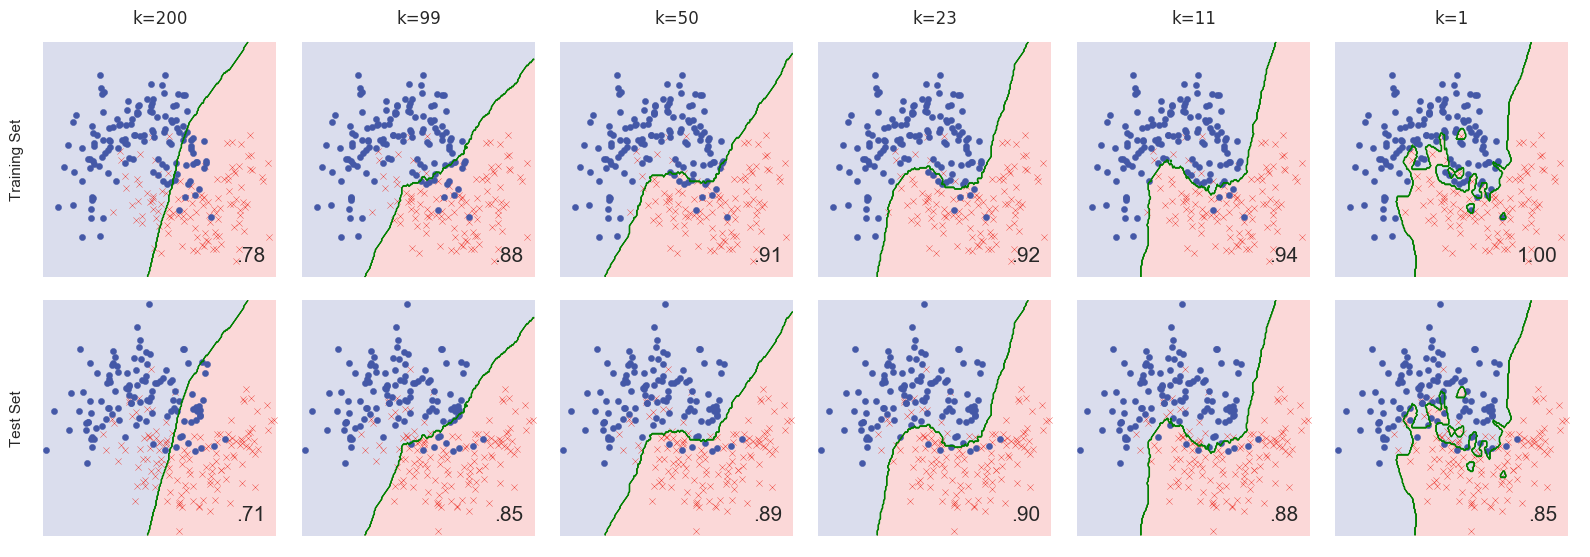

In [12]:
# Split into training and test sets
XTrain, XTest, yTrain, yTest = train_test_split(X, y, random_state=1, test_size=0.5)

# specify the model and settings
model = KNeighborsClassifier()
n_neighbors = [200, 99, 50, 23, 11, 1]
datasets = {
    "Training Set": [XTrain, yTrain],
    "Test Set": [XTest, yTest]
}
width = 20

explore_fitting_boundaries(model=model, n_neighbors=n_neighbors, datasets=datasets, width=width)


## Conclusions and take-away

1. k-NN is a very simple method that can be used for classification. (It can be used for regression too! How?)  

+ Model accuracy (measured on the training dataset) and generalizability (measured on the testing dataset) are both important and often in contention with one another. Model accuracy can be measured using the confusion matrix or the percent of misclassified samples. Generalizability can be measured via cross validation. 

+ Picking parameters in models (such as k in k-NN) is non-trivial, but can be done via cross validation. 

### Exercise
Use k-NN to classify the dataset from the previous lecture comparing hours studied vs. passing exam. What's the best value of k here? 

### Classification method preview
For a preview of upcoming classification methods, see the comparison [here](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).

A figure from this website:
![](plot_classifier_comparison.png)
